In [20]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [21]:
with open(pickle_dir / 'population_patterns_checks_long_withdash.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [25]:
window = population_patterns["window"]
fr_smoothing_window = population_patterns["fr_smoothing_window"]
l2_normalization = population_patterns["l2_normalization"]
min_hop_gap = population_patterns["min_hop_gap"]
population_patterns.pop("window", None)
population_patterns.pop("fr_smoothing_window", None)
population_patterns.pop("l2_normalization", None)
population_patterns.pop("min_hop_gap", None)

20

## Cache v Retrieval of Same Cache

In [ ]:
# Collect reactivation instances
cache_reactiv_vectors = []
cache_details = []
retriev_reactiv_vectors = []
retriev_details = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f, min_hop_gap=min_hop_gap)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    hop_times = population_patterns[fil_string]['hop_times']
    hop_details = population_patterns[fil_string]['hop_details'] # start, peak, end, len

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(cache_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            cache_reactiv_vector = np.nanmax(overlap_matrix, axis=0)
            retriev_reactiv_vector = np.nanmax(overlap_matrix, axis=1)
            cache_reactiv_vectors.append(cache_reactiv_vector)
            retriev_reactiv_vectors.append(retriev_reactiv_vector)
            cache_details.append(hop_details[c_hop, :])
            retriev_details.append(hop_details[r_hop, :])
            break
cache_reactiv_vectors = np.array(cache_reactiv_vectors)
cache_details = np.array(cache_details)
retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
retriev_details = np.array(retriev_details)

In [5]:
cache_reactiv_vectors = np.array(cache_reactiv_vectors)
cache_details = np.array(cache_details)

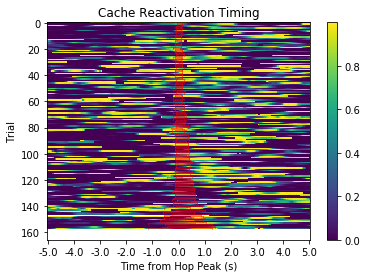

In [6]:
# Plot heatmap of each cache instance, sorted by hop length
sorting = np.argsort(cache_details[:,3]).squeeze()
plt.figure()
normed_cache_reactiv_vectors = []
for vec in cache_reactiv_vectors:
    normed_cache_reactiv_vectors.append(vec)#/np.linalg.norm(vec))
normed_cache_reactiv_vectors = np.array(normed_cache_reactiv_vectors)
plt.imshow(normed_cache_reactiv_vectors[sorting])
for row, hop_detail in enumerate(cache_details[sorting]):
    start = hop_detail[0]
    peak = hop_detail[1]
    end = hop_detail[2]
    plt.plot([start, end], [row, row], "r", linewidth=0.5)
    plt.plot([end, end], [row, row + 1], "r", linewidth=0.5)
    plt.plot([start, start], [row, row + 1], "r", linewidth=0.5)
plt.ylabel("Trial")
plt.xlabel("Time from Hop Peak (s)")
plt.xticks(np.arange(0, window_size*2+1, 20), (np.arange(0, window_size*2+1, 20) - window_size)/20)
plt.title("Cache Reactivation Timing")
plt.colorbar()
#plt.savefig("timing.png", dpi=200)
plt.show()

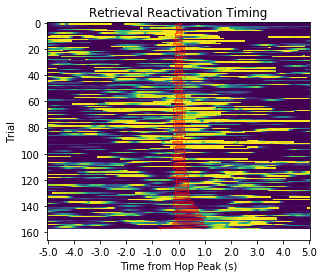

In [7]:
# Plot heatmap of each retrival instance, sorted by hop length
retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
retriev_details = np.array(retriev_details)
sorting = np.argsort(retriev_details[:,3]).squeeze()
plt.figure()   
plt.imshow(retriev_reactiv_vectors[sorting])
for row, hop_detail in enumerate(retriev_details[sorting]):
    start = hop_detail[0]
    peak = hop_detail[1]
    end = hop_detail[2]
    plt.plot([start, end], [row, row], "r", linewidth=0.5)
    plt.plot([end, end], [row, row + 1], "r", linewidth=0.5)
    plt.plot([start, start], [row, row + 1], "r", linewidth=0.5)
plt.ylabel("Trial")
plt.xlabel("Time from Hop Peak (s)")
plt.xticks(np.arange(0, window_size*2+1, 20), (np.arange(0, window_size*2+1, 20) - window_size)/20)
plt.title("Retrieval Reactivation Timing")
plt.savefig("timing_r.png", dpi=200)
plt.show()

## Cache v Retrieval of Same Cache, Normalized Time

In [27]:
# Collect reactivation instances
cache_reactiv_vectors = []
cache_details = []
cache_pokes = []
retriev_reactiv_vectors = []
retriev_details = []
retriev_pokes = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f, min_hop_gap=min_hop_gap)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    hop_times = population_patterns[fil_string]['hop_times']
    hop_details = population_patterns[fil_string]['hop_details'] # start, peak, end, len

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(cache_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            cache_reactiv_vector = np.nanmax(overlap_matrix, axis=0)
            retriev_reactiv_vector = np.nanmax(overlap_matrix, axis=1)
            cache_reactiv_vectors.append(cache_reactiv_vector)
            retriev_reactiv_vectors.append(retriev_reactiv_vector)
            cache_details.append(hop_details[c_hop, :])
            retriev_details.append(hop_details[r_hop, :])
            cache_pokes.append(
                exp_data.event_pokes[exp_data.cache_event][i] - hop_times[c_hop, 0]
                )
            retriev_pokes.append(
                exp_data.event_pokes[exp_data.retriev_event][j] - hop_times[r_hop, 0]
                )
            break
cache_reactiv_vectors = np.array(cache_reactiv_vectors)
cache_details = np.array(cache_details)
retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
retriev_details = np.array(retriev_details)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered


In [28]:
cache_reactiv_vectors = np.array(cache_reactiv_vectors)
cache_details = np.array(cache_details)
cache_pokes = np.array(cache_pokes)
retriev_pokes = np.array(retriev_pokes)

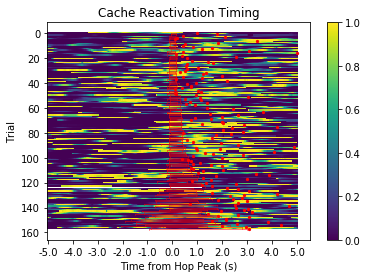

In [29]:
# Plot heatmap of each cache instance, sorted by hop length
sorting = np.argsort(cache_details[:,3]).squeeze()
plt.figure()
normed_cache_reactiv_vectors = []
for vec in cache_reactiv_vectors:
    normed_cache_reactiv_vectors.append(vec)#/np.linalg.norm(vec))
normed_cache_reactiv_vectors = np.array(normed_cache_reactiv_vectors)
plt.imshow(normed_cache_reactiv_vectors[sorting])
for row, hop_detail in enumerate(cache_details[sorting]):
    start = hop_detail[0]
    peak = hop_detail[1]
    end = hop_detail[2]
    plt.plot([start, end], [row, row], "r", linewidth=0.5)
    plt.plot([end, end], [row, row + 1], "r", linewidth=0.5)
    plt.plot([start, start], [row, row + 1], "r", linewidth=0.5)
    poke = cache_pokes[sorting][row]
    if poke < window_size*2+1:
        plt.scatter(poke, row, s=5, c="r")
plt.ylabel("Trial")
plt.xlabel("Time from Hop Peak (s)")
plt.xticks(np.arange(0, window_size*2+1, 20), (np.arange(0, window_size*2+1, 20) - window_size)/20)
plt.title("Cache Reactivation Timing")
plt.colorbar()
#plt.savefig("timing.png", dpi=200)
plt.show()

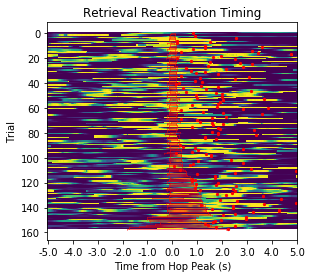

In [30]:
# Plot heatmap of each retrival instance, sorted by hop length
retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
retriev_details = np.array(retriev_details)
sorting = np.argsort(retriev_details[:,3]).squeeze()
plt.figure()   
plt.imshow(retriev_reactiv_vectors[sorting])
for row, hop_detail in enumerate(retriev_details[sorting]):
    start = hop_detail[0]
    peak = hop_detail[1]
    end = hop_detail[2]
    plt.plot([start, end], [row, row], "r", linewidth=0.5)
    plt.plot([end, end], [row, row + 1], "r", linewidth=0.5)
    plt.plot([start, start], [row, row + 1], "r", linewidth=0.5)
    poke = retriev_pokes[sorting][row]
    if poke < window_size*2+1:
        plt.scatter(poke, row, s=5, c="r")
plt.ylabel("Trial")
plt.xlabel("Time from Hop Peak (s)")
plt.xticks(np.arange(0, window_size*2+1, 20), (np.arange(0, window_size*2+1, 20) - window_size)/20)
plt.title("Retrieval Reactivation Timing")
plt.savefig("timing_r.png", dpi=200)
plt.show()

## Full Check v Retrieval of Same Cache, Normalized Time

In [31]:
# Collect reactivation instances
check_reactiv_vectors = []
check_details = []
check_pokes = []
retriev_reactiv_vectors = []
retriev_details = []
retriev_pokes = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f, min_hop_gap=20)
    ch_hops = population_patterns[fil_string]['ch_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    hop_times = population_patterns[fil_string]['hop_times']
    hop_details = population_patterns[fil_string]['hop_details'] # start, peak, end, len

    for i, ch_hop in enumerate(ch_hops):
        ch_site = exp_data.event_sites[exp_data.check_event][i]
        check_pattern_mat = hop_patterns[ch_hop]
        if not exp_data.cache_present[ch_hop, ch_site-1]: continue
        for j, r_hop in enumerate(r_hops):
            if r_hop <= ch_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != ch_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                check_retriev_overlap = popln_overlap(
                    check_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(check_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            check_reactiv_vector = np.nanmax(overlap_matrix, axis=0)
            retriev_reactiv_vector = np.nanmax(overlap_matrix, axis=1)
            check_reactiv_vectors.append(check_reactiv_vector)
            retriev_reactiv_vectors.append(retriev_reactiv_vector)
            check_details.append(hop_details[ch_hop, :])
            retriev_details.append(hop_details[r_hop, :])
            check_pokes.append(
                exp_data.event_pokes[exp_data.check_event][i] - hop_times[ch_hop, 0]
                )
            retriev_pokes.append(
                exp_data.event_pokes[exp_data.retriev_event][j] - hop_times[r_hop, 0]
                )
            break
check_reactiv_vectors = np.array(check_reactiv_vectors)
check_details = np.array(check_details)
retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
retriev_details = np.array(retriev_details)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


In [32]:
check_reactiv_vectors = np.array(check_reactiv_vectors)
check_details = np.array(check_details)
check_pokes = np.array(check_pokes)
retriev_pokes = np.array(retriev_pokes)

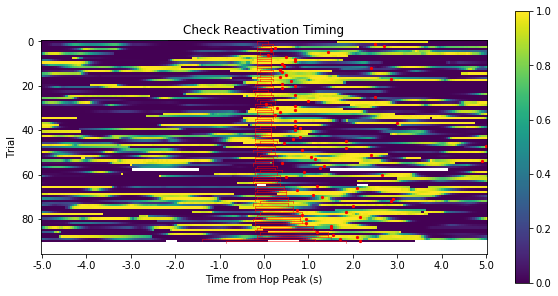

In [37]:
# Plot heatmap of each check instance, sorted by hop length
sorting = np.argsort(check_details[:,3]).squeeze()
plt.figure(figsize=(10,5))
normed_check_reactiv_vectors = []
for vec in check_reactiv_vectors:
    normed_check_reactiv_vectors.append(vec)#/np.linalg.norm(vec))
normed_check_reactiv_vectors = np.array(normed_check_reactiv_vectors)
plt.imshow(normed_check_reactiv_vectors[sorting])
for row, hop_detail in enumerate(check_details[sorting]):
    start = hop_detail[0]
    peak = hop_detail[1]
    end = hop_detail[2]
    plt.plot([start, end], [row, row], "r", linewidth=0.5)
    plt.plot([end, end], [row, row + 1], "r", linewidth=0.5)
    plt.plot([start, start], [row, row + 1], "r", linewidth=0.5)
    poke = check_pokes[sorting][row]
    if poke < window_size*2+1:
        plt.scatter(poke, row, s=5, c="r")
plt.ylabel("Trial")
plt.xlabel("Time from Hop Peak (s)")
plt.xticks(np.arange(0, window_size*2+1, 20), (np.arange(0, window_size*2+1, 20) - window_size)/20)
plt.title("Check Reactivation Timing")
plt.colorbar()
#plt.savefig("timing.png", dpi=200)
plt.show()

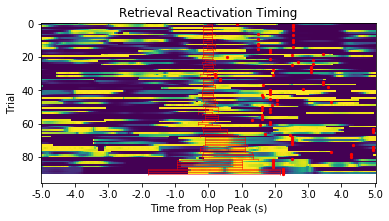

In [34]:
# Plot heatmap of each retrival instance, sorted by hop length
retriev_reactiv_vectors = np.array(retriev_reactiv_vectors)
retriev_details = np.array(retriev_details)
sorting = np.argsort(retriev_details[:,3]).squeeze()
plt.figure()   
plt.imshow(retriev_reactiv_vectors[sorting])
for row, hop_detail in enumerate(retriev_details[sorting]):
    start = hop_detail[0]
    peak = hop_detail[1]
    end = hop_detail[2]
    plt.plot([start, end], [row, row], "r", linewidth=0.5)
    plt.plot([end, end], [row, row + 1], "r", linewidth=0.5)
    plt.plot([start, start], [row, row + 1], "r", linewidth=0.5)
    poke = retriev_pokes[sorting][row]
    if poke < window_size*2+1:
        plt.scatter(poke, row, s=5, c="r")
plt.ylabel("Trial")
plt.xlabel("Time from Hop Peak (s)")
plt.xticks(np.arange(0, window_size*2+1, 20), (np.arange(0, window_size*2+1, 20) - window_size)/20)
plt.title("Retrieval Reactivation Timing")
plt.savefig("timing_r.png", dpi=200)
plt.show()